# 4 Task A: Individual Neural Networks for Each Forecast Horizon

## 4.1 Data Preparation

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import joblib
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from scipy.stats import pearsonr
import math
from sklearn.metrics import mean_squared_error

### (a) Load the data from Nino3.4 data.csv

In [20]:
data = pd.read_csv("Nino3.4_data.csv")

### (b) Read test years from test years.csv. Extract all data rows from step (a) that match these test years to create your test set. This test data must remain untouched during training. You should use this test set to evaluate your model’s performance and report results

In [21]:
test_years = pd.read_csv("test_years.csv")["year"].tolist()

### (c) Subset your test data based on the test years, then randomly partition the remainingdataset into training and validation sets. Choose an appropriate split ratio that ensures sufficient data for both training and validation.

In [22]:
test_data = data[data["year"].isin(test_years)].reset_index(drop=True)
train_val_data = data[~data["year"].isin(test_years)].reset_index(drop=True)

# 在剩余数据中随机划分训练集与验证集
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42, shuffle=True)

### (d) Pre-processing: Apply scaling transformations to the input features (nino tminus2, nino tminus1, nino t). Scaling the target variables (nino tplus1 through nino tplus6) is optional - if you choose to scale them, save the target scalers for inverse transformation during evaluation. Apply the same transformations to the validation set.

Optional: You might also consider creating additional features from the month column. For example, some students find it helpful to encode the cyclical nature of months using sine and cosine transformations: sin(2π × month/12) and cos(2π × month/12). This can help the model understand that December is adjacent to January.

Note: Save your scaler objects for later use (e.g., using pickle or joblib).

In [23]:
# 输入特征与目标列
input_features = ["nino_tminus2", "nino_tminus1", "nino_t"]
target_features = ["nino_tplus1", "nino_tplus2", "nino_tplus3", "nino_tplus4", "nino_tplus5", "nino_tplus6"]

# 可选：添加月份的正弦余弦特征
for df in [train_data, val_data, test_data]:
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    # 将它们加入输入特征中
    df.reset_index(drop=True, inplace=True)

input_features_extended = input_features + ["month_sin", "month_cos"]

# 缩放输入特征
scaler_X = StandardScaler()
train_X_scaled = scaler_X.fit_transform(train_data[input_features_extended])
val_X_scaled = scaler_X.transform(val_data[input_features_extended])
test_X_scaled = scaler_X.transform(test_data[input_features_extended])

# 可选：缩放目标变量
scale_targets = True  # ← 如果不希望缩放，改成 False
if scale_targets:
    scaler_y = StandardScaler()
    train_y_scaled = scaler_y.fit_transform(train_data[target_features])
    val_y_scaled = scaler_y.transform(val_data[target_features])
    test_y_scaled = scaler_y.transform(test_data[target_features])
else:
    train_y_scaled = train_data[target_features].values
    val_y_scaled = val_data[target_features].values
    test_y_scaled = test_data[target_features].values
    scaler_y = None

# 保存缩放器以供后续反缩放或预测使用
joblib.dump(scaler_X, "scaler_X.pkl")
if scaler_y:
    joblib.dump(scaler_y, "scaler_y.pkl")

# ---------- 转换为 PyTorch 张量 ----------
train_X = torch.tensor(train_X_scaled, dtype=torch.float32)
val_X = torch.tensor(val_X_scaled, dtype=torch.float32)
test_X = torch.tensor(test_X_scaled, dtype=torch.float32)

train_y = torch.tensor(train_y_scaled, dtype=torch.float32)
val_y = torch.tensor(val_y_scaled, dtype=torch.float32)
test_y = torch.tensor(test_y_scaled, dtype=torch.float32)

# ---------- 创建 TensorDataset ----------
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
test_dataset = TensorDataset(test_X, test_y)

# 示例：构建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 584
Val size: 146
Test size: 72


### (e) Train a neural network that predicts the Ni˜no3.4 index of the next month, i.e.nino tplus1 using reasonable hyperparameters. Ensure reproducibility by setting a seed throughout your code. Plot the training and validation loss curves across epochs.
Note: Save your trained models in a format appropriate for your chosen framework. Common formats include .keras, .h5, .pth, .pt, or .onnx. Ensure your models can be loaded during evaluation

In [24]:
# ---------- 设置随机种子以确保可复现性 ----------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 如果有GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 定义神经网络 ----------
class NinoNet(nn.Module):
    def __init__(self, input_dim):
        super(NinoNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

input_dim = train_X.shape[1]
model = NinoNet(input_dim).to(device)


### (f) Repeat (e) for the subsequent months, i.e., nino_tplus2, nino_tplus3,.. nino_tplus6. Together with part (e), this will give you six trained networks and six plots for training and validation loss, shown in one Figure


===== Training Model for Horizon 1 Month =====
 模型 nino_model_tplus1.pth 已保存

===== Training Model for Horizon 2 Month =====
 模型 nino_model_tplus2.pth 已保存

===== Training Model for Horizon 3 Month =====
 模型 nino_model_tplus3.pth 已保存

===== Training Model for Horizon 4 Month =====
 模型 nino_model_tplus4.pth 已保存

===== Training Model for Horizon 5 Month =====
 模型 nino_model_tplus5.pth 已保存

===== Training Model for Horizon 6 Month =====
 模型 nino_model_tplus6.pth 已保存


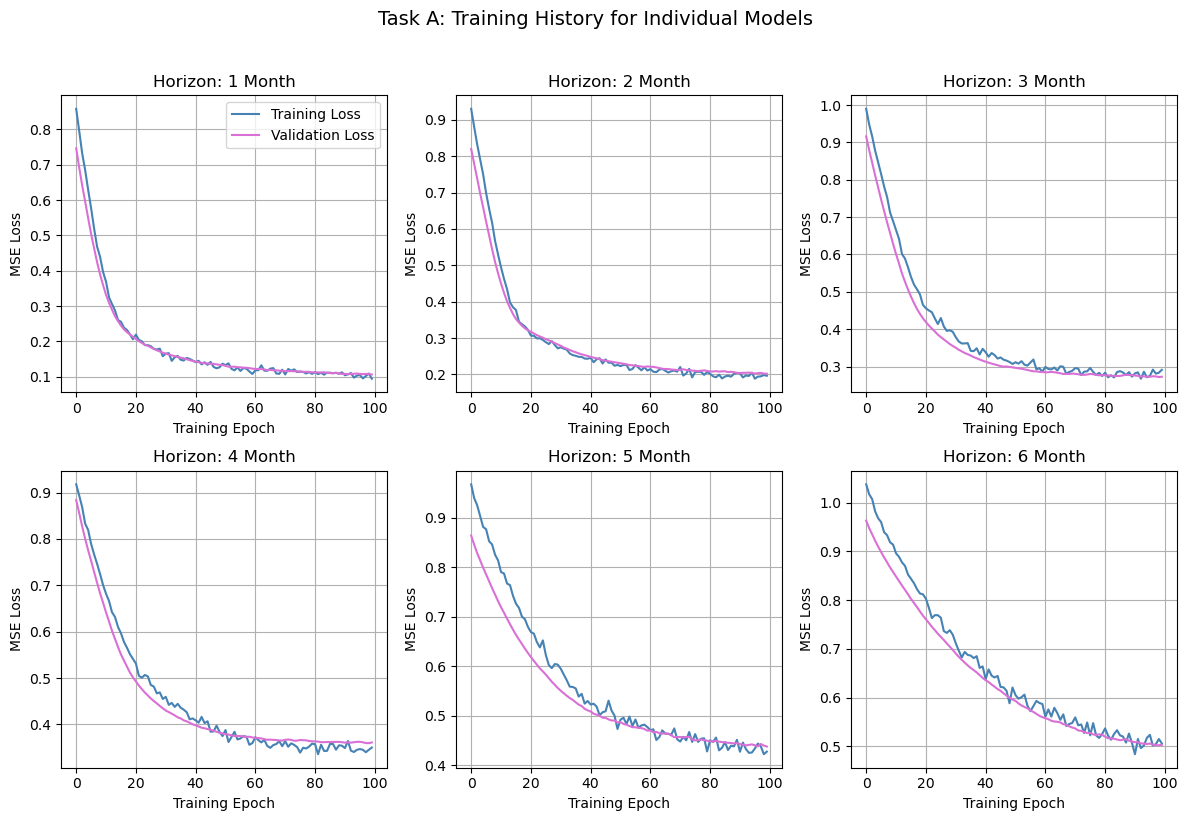

In [25]:
# ---------- 训练函数 ----------
def train_single_horizon(horizon_index, epochs=100, lr=1e-4, batch_size=32):
    # 目标列索引
    y_train_h = train_y[:, horizon_index].unsqueeze(1)
    y_val_h = val_y[:, horizon_index].unsqueeze(1)

    # 数据加载
    train_dataset = TensorDataset(train_X, y_train_h)
    val_dataset = TensorDataset(val_X, y_val_h)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # 模型定义
    model = NinoNet(train_X.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()

    # 记录损失
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * Xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                out = model(Xb)
                loss = criterion(out, yb)
                total_val_loss += loss.item() * Xb.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

    # 保存模型
    torch.save(model.state_dict(), f"nino_model_tplus{horizon_index+1}.pth")
    print(f" 模型 nino_model_tplus{horizon_index+1}.pth 已保存")

    return train_losses, val_losses


# ---------- 主训练循环 ----------
all_train_losses, all_val_losses = [], []
num_models = 6
for i in range(num_models):
    print(f"\n===== Training Model for Horizon {i+1} Month =====")
    t_loss, v_loss = train_single_horizon(i)
    all_train_losses.append(t_loss)
    all_val_losses.append(v_loss)


# ---------- 绘制六张训练曲线 ----------
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(num_models):
    ax = axes[i]
    ax.plot(all_train_losses[i], label="Training Loss", color="steelblue")
    ax.plot(all_val_losses[i], label="Validation Loss", color="orchid")
    ax.set_title(f"Horizon: {i+1} Month")
    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("MSE Loss")
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.suptitle("Task A: Training History for Individual Models", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### (j) Apply the same transformations to the test set as you did to the training and validation sets

In [ ]:
# 假设 scaler_X 是在 (d) 中已经 fit 过的输入特征缩放器
# 如果你也对目标缩放过（可选），那也有 scaler_y
# ⚠️ 这里我们不重新fit，只transform
X_features = ['nino_tminus2', 'nino_tminus1', 'nino_t', 'month_sin', 'month_cos']
y_targets = ['nino_tplus1', 'nino_tplus2', 'nino_tplus3', 
             'nino_tplus4', 'nino_tplus5', 'nino_tplus6']

# 对测试集的输入特征应用与训练集相同的缩放器
X_test_scaled = scaler_X.transform(test_data[X_features])

# 如果你对目标变量也缩放过：
y_test_scaled = scaler_y.transform(test_data[y_targets])
# 否则直接使用原始值
# y_test_scaled = test_data[y_targets].values

# 转成Tensor格式，方便后续预测
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

print("测试集转换完成：")
print(f"X_test_tensor: {X_test_tensor.shape}, y_test_tensor: {y_test_tensor.shape}")

✅ 测试集转换完成：
X_test_tensor: torch.Size([72, 5]), y_test_tensor: torch.Size([72, 6])


### (k) Use your models to forecast the Ni˜no3.4 index on the test set for the months ahead they are designed for

In [39]:
# 假设模型结构一致
class NinoNet(nn.Module):
    def __init__(self, input_dim):
        super(NinoNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# 载入模型并预测
horizons = [1, 2, 3, 4, 5, 6]
results = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### (l) Evaluate each model by calculating the RMSE and Pearson Correlation Coefficient between the predicted and true values (as defined in Section 3.4).

In [43]:
for h in horizons:
    # 加载模型
    model = NinoNet(input_dim=X_test_tensor.shape[1]).to(device)
    model.load_state_dict(torch.load(f"nino_model_tplus{h}.pth", map_location=device))
    model.eval()  # 重要：关闭 Dropout

    # 预测
    with torch.no_grad():
        preds = model(X_test_tensor.to(device)).cpu().numpy().flatten()

    # 若目标曾缩放，则需要反变换
    # preds = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
    # true = scaler_y.inverse_transform(y_test_tensor[:, h-1].unsqueeze(1)).flatten()

    true = y_test_tensor[:, h-1].numpy().flatten()

    # 计算 RMSE
    rmse = math.sqrt(mean_squared_error(true, preds))
    # 计算皮尔逊相关系数
    corr, _ = pearsonr(true, preds)

    results.append({"Horizon (month ahead)": h, "RMSE": rmse, "Pearson r": corr})

### (m) Display results in a table showing RMSE and correlation coefficients for each forecast horizon (1-6 months ahead

In [44]:
# 汇总结果表
results_df = pd.DataFrame(results)
print("📊 预测评估结果：")
print(results_df.to_string(index=False))

📊 预测评估结果：
 Horizon (month ahead)     RMSE  Pearson r
                     1 0.267830   0.970548
                     2 0.408842   0.926400
                     3 0.541327   0.868880
                     4 0.648074   0.803977
                     5 0.764654   0.719993
                     6 0.824923   0.668906


### 4.4 Model Improvements
(n) Apply a strategy that involves transfer learning to the model that predicts nino tplus6 and calculate the RMSE and correlation coefficient on the testing data.
Hint: First train a model on an easier task such as nino tplus1, then continue
training the same model to predict nino tplus6

In [48]:
# ========== 重新准备 tplus6 的训练与测试数据 ==========
# 使用之前缩放后的输入
X_train_tensor = torch.tensor(train_X_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(test_X_scaled, dtype=torch.float32).to(device)

# 输出变量：nino_tplus6
y_train_tplus6 = train_data["nino_tplus6"].values.reshape(-1, 1)
y_test_tplus6 = test_data["nino_tplus6"].values.reshape(-1, 1)

# 如果你曾对目标变量进行了缩放，请改为 scaler_y.transform(...) 再转换成 tensor

y_train_tplus6_tensor = torch.tensor(y_train_tplus6, dtype=torch.float32).to(device)
y_test_tplus6_tensor = torch.tensor(y_test_tplus6, dtype=torch.float32).to(device)

# ---------- (1) 初始化模型并加载 tplus1 的权重 ----------
source_model_path = "nino_model_tplus1.pth"
target_model_path = "nino_model_transfer_tplus6.pth"

input_dim = X_train_tensor.shape[1]
model = NinoNet(input_dim).to(device)

# 加载源模型参数
state_dict = torch.load(source_model_path, map_location=device)
model.load_state_dict(state_dict)

# 解冻除第一层外的所有层
for name, param in model.model.named_parameters():
    if "0" in name:
        param.requires_grad = False


# ---------- (3) 替换输出层 ----------
model.model[-1] = nn.Linear(32, 1).to(device)

# ---------- (4) 定义优化器与损失函数 ----------
criterion = nn.MSELoss()
# 调高学习率 + 加强正则
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                       lr=5e-4, weight_decay=1e-4)

# 增加训练轮次与早停机制
best_val_loss = float('inf')
patience, patience_counter = 20, 0

# ---------- (5) 迁移训练 ----------
epochs = 300
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tplus6_tensor)
    loss.backward()
    optimizer.step()

    # 简单 early stop
    if loss.item() < best_val_loss:
        best_val_loss = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/300], Loss: {loss.item():.4f}")

# 保存微调后的模型
torch.save(model.state_dict(), target_model_path)

# ---------- (6) 在测试集上评估 ----------
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy().flatten()
    y_true = y_test_tplus6_tensor.cpu().numpy().flatten()

rmse_transfer = np.sqrt(mean_squared_error(y_true, y_pred))
corr_transfer, _ = pearsonr(y_true, y_pred)

print("\n📈 Transfer Learning Results for Nino_tplus6:")
print(f"RMSE: {rmse_transfer:.4f}")
print(f"Pearson r: {corr_transfer:.4f}")

Epoch [20/300], Loss: 0.6548
Epoch [40/300], Loss: 0.5808
Epoch [60/300], Loss: 0.5299
Epoch [80/300], Loss: 0.4910
Epoch [100/300], Loss: 0.4628
Epoch [120/300], Loss: 0.4316
Epoch [140/300], Loss: 0.4245
Epoch [160/300], Loss: 0.4064
Early stopping at epoch 180

📈 Transfer Learning Results for Nino_tplus6:
RMSE: 0.7510
Pearson r: 0.6544
